In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from glob import glob
import cv2
import torch
from PIL import Image
import json


In [2]:
import os
import torch
from load_data import load_data
from rsl_depth_completion.conditional_diffusion.pipeline_utils import (
    get_ds_kwargs,
    setup_train_pipeline,
)

from rsl_depth_completion.conditional_diffusion.pipeline_utils import create_tracking_exp

torch.backends.cudnn.benchmark = True


logdir_name = "debug"

out_dir = f"/tmp/{logdir_name}" 
os.makedirs(out_dir, exist_ok=True)
# logdir_name = "standalone_trainer"
cfg, train_logdir = setup_train_pipeline(logdir_name, use_ssl=True)
cfg.disabled = True
cfg.input_res = 256
cfg.unets_output_res = [64,256]
cfg.only_super_res = True
cfg.use_triplet_loss=True

experiment = create_tracking_exp(cfg)

ds_kwargs = get_ds_kwargs(cfg)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)
x=ds[0]
eval_batch = ds.eval_batch

print(x['cond_img'].shape)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


torch.Size([1, 256, 256])


In [3]:
from kbnet.kbnet_model import KBNetModel
from argparse import Namespace
from kbnet.net_utils import OutlierRemoval
from kbnet.transforms import Transforms
from kbnet import eval_utils

args = Namespace(**json.load(open('kbnet_val_params.json', 'r')))

ground_truth_available = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
outlier_removal = OutlierRemoval(
    kernel_size=args.outlier_removal_kernel_size,
    threshold=args.outlier_removal_threshold,
)
transforms = Transforms(
        normalized_image_range=args.normalized_image_range)
save_outputs = True


In [4]:
from rsl_depth_completion.diffusion.utils import set_seed

from rsl_depth_completion.conditional_diffusion.ssl_utils import calc_error_to_gt, plot_losses


In [24]:
from rsl_depth_completion.conditional_diffusion.utils import get_pose_model
set_seed(40)
depth_model = KBNetModel(
    input_channels_image=args.input_channels_image,
    input_channels_depth=args.input_channels_depth,
    min_pool_sizes_sparse_to_dense_pool=args.min_pool_sizes_sparse_to_dense_pool,
    max_pool_sizes_sparse_to_dense_pool=args.max_pool_sizes_sparse_to_dense_pool,
    n_convolution_sparse_to_dense_pool=args.n_convolution_sparse_to_dense_pool,
    n_filter_sparse_to_dense_pool=args.n_filter_sparse_to_dense_pool,
    n_filters_encoder_image=args.n_filters_encoder_image,
    n_filters_encoder_depth=args.n_filters_encoder_depth,
    resolutions_backprojection=args.resolutions_backprojection,
    n_filters_decoder=args.n_filters_decoder,
    deconv_type=args.deconv_type,
    weight_initializer=args.weight_initializer,
    activation_func=args.activation_func,
    min_predict_depth=args.min_predict_depth,
    max_predict_depth=args.max_predict_depth,
    device=args.device,
)

# Restore model and set to evaluation mode
# depth_model.restore_model(args.depth_model_restore_path)

pose_model = get_pose_model(device)

depth_model.train()
pose_model.train()
# depth_model.eval()
# pose_model.eval()

parameters_depth_model = depth_model.parameters()
parameters_pose_model = pose_model.parameters()
w_weight_decay_depth = 0
w_weight_decay_pose = 0
# learning_rate = 1e-4
learning_rate = 5e-5
optimizer = torch.optim.Adam(
    [
        {"params": parameters_depth_model, "weight_decay": w_weight_decay_depth},
        {"params": parameters_pose_model, "weight_decay": w_weight_decay_pose},
    ],
    lr=learning_rate,
)

In [10]:
ds.ds.do_crop = False
batch_size=4
dataloader = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
)
x=ds[0]
overfit_batch = torch.utils.data.default_collate([x]*batch_size)
x['sdm'].shape

torch.Size([1, 352, 1216])

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

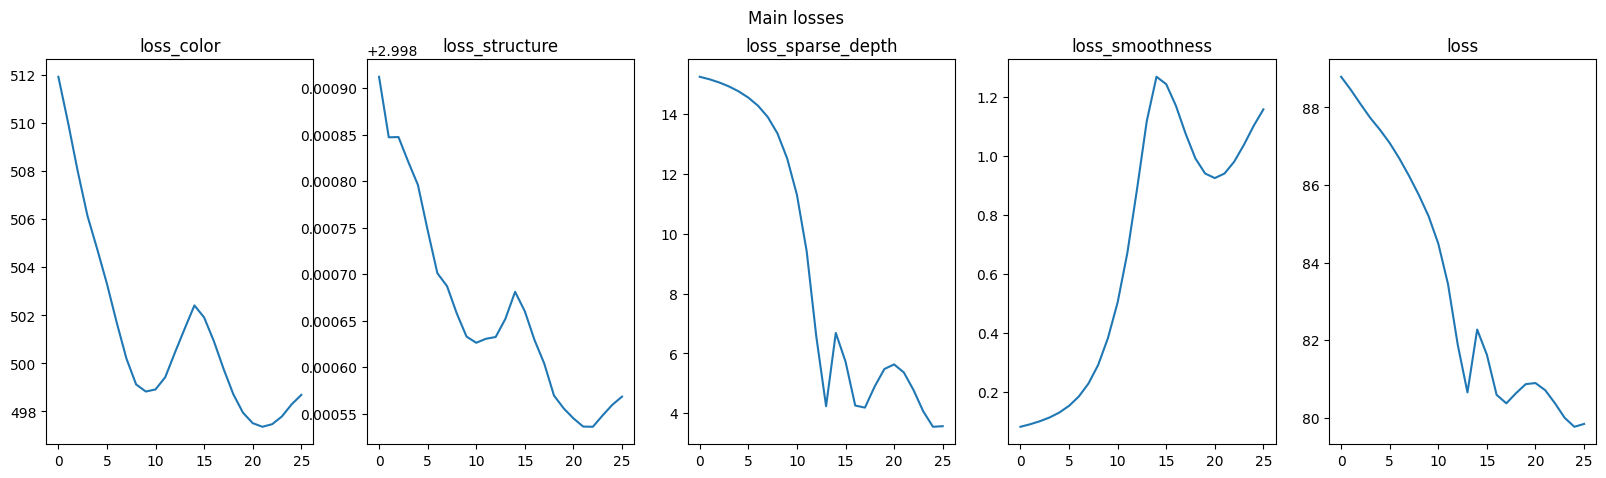

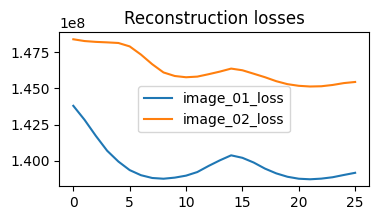

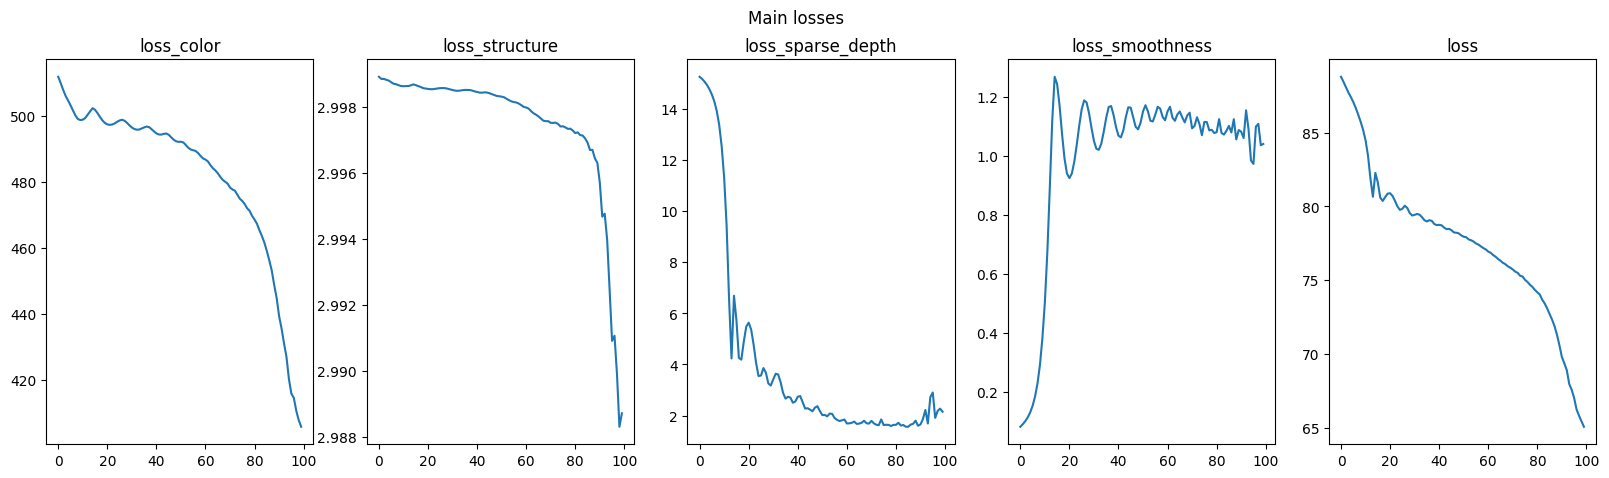

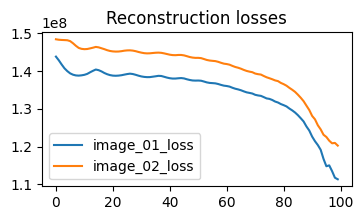

Evaluation results
     MAE      RMSE      iMAE     iRMSE
2633.430  4295.077    34.116    93.841
     +/-       +/-       +/-       +/-
   0.000     0.000     0.000     0.000


In [25]:
from tqdm.auto import tqdm


n_sample = 1
num_epochs = 100
mae = np.zeros(n_sample)
rmse = np.zeros(n_sample)
imae = np.zeros(n_sample)
irmse = np.zeros(n_sample)
w_color = 0.15
w_structure = 0.95
w_sparse_depth = 0.60
w_smoothness = 0.04
images = []
output_depths = []
sparse_depths = []

time_elapse = 0.0
rec_losses = {
    "image_01_loss": [],
    "image_02_loss": [],
}
losses = {
    "loss_color": [],
    "loss_structure": [],
    "loss_sparse_depth": [],
    "loss_smoothness": [],
    "loss": [],
}
depth_grads = {k: [] for k in range(len(parameters_depth_model))}
pose_grads = {k: [] for k in range(len(parameters_pose_model))}
plot_every = (num_epochs-1)//2
plot_epochs = [num_epochs//4, num_epochs-1]
maes = []
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    # for idx, (batch) in enumerate(dataloader):
    for idx, (batch) in enumerate([overfit_batch]):
        if idx == n_sample:
            break
        # Move inputs to device
        (batch) = {k: in_.to(device) for k, in_ in (batch).items()}

        image, sparse_depth, intrinsics = (
            (batch)["rgb"],
            (batch)["sdm"],
            (batch)["intrinsics"],
        )

        adj_imgs = batch["adj_imgs"]

        image0 = batch["rgb"]
        
        image1 = adj_imgs[:, 0]
        image2 = adj_imgs[:, 1]
        filtered_sparse_depth0 = batch["sdm"]
        intrinsics = batch["intrinsics"]

        pose01 = pose_model.forward(image0, image1)
        pose02 = pose_model.forward(image0, image2)

        validity_map_depth = torch.where(
            sparse_depth > 0, torch.ones_like(sparse_depth), sparse_depth
        )
        filtered_validity_map_depth0 = validity_map_depth

        # Remove outlier points and update sparse depth and validity map
        (
            filtered_sparse_depth,
            filtered_validity_map_depth,
        ) = outlier_removal.remove_outliers(
            sparse_depth=sparse_depth, validity_map=validity_map_depth
        )

        [image] = transforms.transform(
            images_arr=[image], random_transform_probability=0.0
        )

        # Forward through network
        output_depth = depth_model.forward(
            image=image,
            sparse_depth=sparse_depth,
            validity_map_depth=filtered_validity_map_depth,
            intrinsics=intrinsics,
        )

        # Convert to numpy
        output_depth0 = output_depth
        output_depth = np.squeeze(output_depth.detach().cpu().numpy())

        pose01 = pose_model.forward(image0, image1)
        pose02 = pose_model.forward(image0, image2)

        # Compute loss function
        loss, loss_info = depth_model.compute_loss(
            image0=image0,
            image1=image1,
            image2=image2,
            output_depth0=output_depth0,
            sparse_depth0=filtered_sparse_depth0,
            validity_map_depth0=filtered_validity_map_depth0,
            intrinsics=intrinsics,
            pose01=pose01,
            pose02=pose02,
            w_color=w_color,
            w_structure=w_structure,
            w_sparse_depth=w_sparse_depth,
            w_smoothness=w_smoothness,
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print(
        #     f"gradients: {[torch.sum(torch.abs(x.grad)) for x in parameters_depth_model if x.grad is not None]}"
        # )
        for i in range(len(parameters_depth_model)):
            if parameters_depth_model[i].grad is not None:
                depth_grads[i].append(
                    torch.sum(torch.abs(parameters_depth_model[i].grad)).item()
                )
        for i in range(len(parameters_pose_model)):
            if parameters_pose_model[i].grad is not None:
                pose_grads[i].append(
                    torch.sum(torch.abs(parameters_pose_model[i].grad)).item()
                )

        image01 = loss_info.get("image01")
        image02 = loss_info.get("image02")
        image01_error_summary = torch.sum(
            torch.mean(torch.abs(image0 - image01), dim=1, keepdim=False)
        ).item()
        image02_error_summary = torch.sum(
            torch.mean(torch.abs(image0 - image02), dim=1, keepdim=False)
        ).item()
        # print("image01 reconstruction L1 loss: ", image01_error_summary)
        # print("image02 reconstruction L1 loss: ", image02_error_summary)
        rec_losses["image_01_loss"].append(image01_error_summary)
        rec_losses["image_02_loss"].append(image02_error_summary)

        loss_keys = [k for k in loss_info.keys() if "loss" in k]
        for loss_key in loss_keys:
            # print(f"{loss_key}: {loss_info[loss_key]}")
            losses[loss_key].append(loss_info[loss_key].item())

        # Save to output
        if save_outputs:
            images.append(np.transpose(np.squeeze(image[-1].cpu().numpy()), (1, 2, 0)))
            sparse_depths.append(np.squeeze(filtered_sparse_depth[-1].cpu().numpy()))
            output_depths.append(output_depth[-1] if len(output_depth.shape) == 3 else output_depth)

        if ground_truth_available:
            ground_truth = (batch)["gt"]
            validity_map = torch.where(
                ground_truth > 0, torch.ones_like(ground_truth), ground_truth
            )
            ground_truth = (
                torch.stack([ground_truth, validity_map], axis=-1).cpu().numpy()
            )
            ground_truth = np.squeeze(ground_truth)
            # if len(output_depth.shape) == 2:
            #     output_depth = output_depth[ np.newaxis, :, :]

            validity_map = ground_truth[..., 1]
            ground_truth = ground_truth[..., 0]

            validity_mask = np.where(validity_map > 0, 1, 0)
            min_max_mask = np.logical_and(
                ground_truth > args.min_evaluate_depth,
                ground_truth < args.max_evaluate_depth,
            )
            mask = np.where(np.logical_and(validity_mask, min_max_mask) > 0)

            output_depth = output_depth[mask]
            ground_truth = ground_truth[mask]

            mae[idx] = eval_utils.mean_abs_err(
                1000.0 * output_depth, 1000.0 * ground_truth
            )
            maes.append(mae[idx])
            rmse[idx] = eval_utils.root_mean_sq_err(
                1000.0 * output_depth, 1000.0 * ground_truth
            )
            imae[idx] = eval_utils.inv_mean_abs_err(
                0.001 * output_depth, 0.001 * ground_truth
            )
            irmse[idx] = eval_utils.inv_root_mean_sq_err(
                0.001 * output_depth, 0.001 * ground_truth
            )
    # if epoch % plot_every == 0 and epoch > 0:
    if epoch in plot_epochs:
        plot_losses(losses, rec_losses)

if ground_truth_available:
    mae_mean = np.mean(mae)
    rmse_mean = np.mean(rmse)
    imae_mean = np.mean(imae)
    irmse_mean = np.mean(irmse)

    mae_std = np.std(mae)
    rmse_std = np.std(rmse)
    imae_std = np.std(imae)
    irmse_std = np.std(irmse)

    # Print evaluation results to console and file
    print("Evaluation results")
    print("{:>8}  {:>8}  {:>8}  {:>8}".format("MAE", "RMSE", "iMAE", "iRMSE"))
    print(
        "{:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}".format(
            mae_mean, rmse_mean, imae_mean, irmse_mean
        )
    )

    print("{:>8}  {:>8}  {:>8}  {:>8}".format("+/-", "+/-", "+/-", "+/-"))
    print(
        "{:8.3f}  {:8.3f}  {:8.3f}  {:8.3f}".format(
            mae_std, rmse_std, imae_std, irmse_std
        )
    )

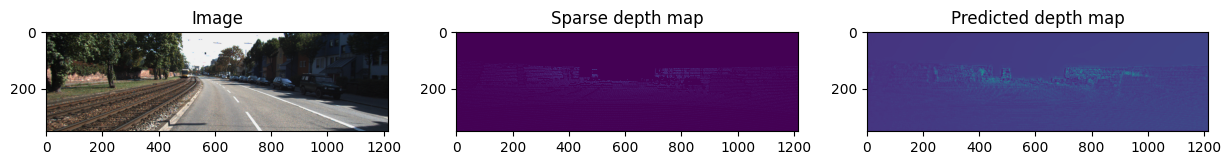

In [26]:
idx = 0
last_sample = (images[idx], output_depths[idx], sparse_depths[idx])
# for i, (img, pred, sdm) in enumerate(zip(images, output_depths, sparse_depths)):
for i, (img, pred, sdm) in enumerate([last_sample]):
    if i==10: break
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img*255)
    axs[1].imshow(sdm)
    axs[2].imshow(pred)
    axs[0].set_title("Image")
    axs[1].set_title("Sparse depth map")
    axs[2].set_title("Predicted depth map")
    plt.show()

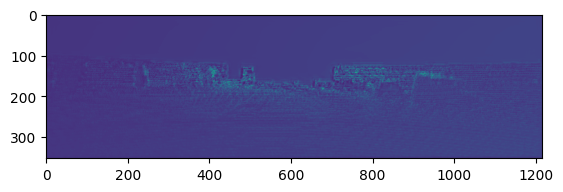

In [25]:
plt.imshow(pred)

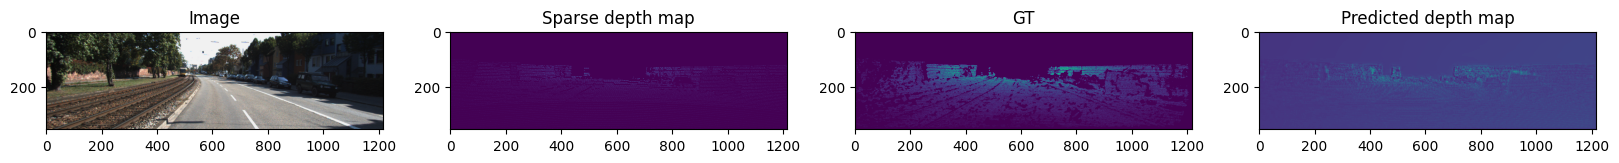

In [27]:
idx=0
img, pred, sdm, gt = images[idx], output_depths[idx], sparse_depths[idx], batch['gt'][-1].cpu()
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(img*255)
axs[1].imshow(sdm)
axs[2].imshow(gt.squeeze())
axs[3].imshow(pred)
axs[0].set_title("Image")
axs[1].set_title("Sparse depth map")
axs[2].set_title("GT")
axs[3].set_title("Predicted depth map")
plt.show()

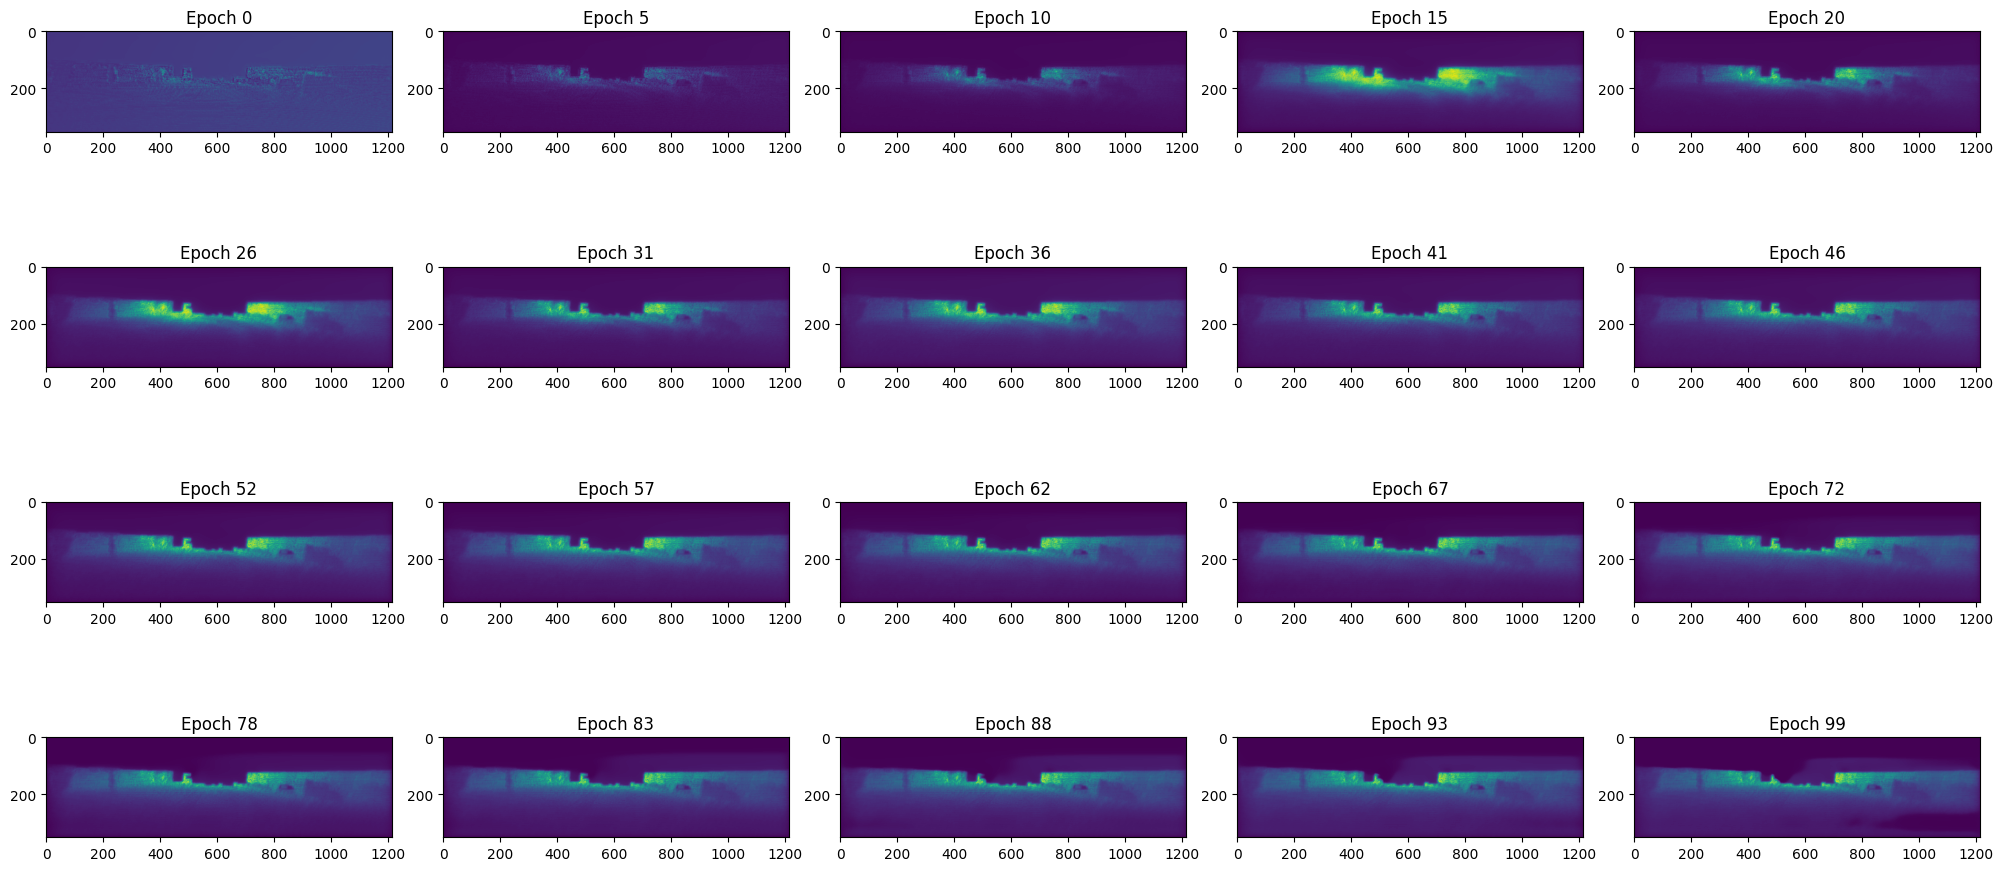

In [28]:
pred_ckpts = np.linspace(0, len(output_depths)-1, 20).astype(int)
fig, axs = plt.subplots(len(pred_ckpts) // 5, 5, figsize=(20, 10))
for i, ckpt in enumerate(pred_ckpts):
    axs[i // 5, i % 5].imshow(output_depths[ckpt])
    axs[i // 5, i % 5].set_title(f"Epoch {ckpt}")
plt.tight_layout()
plt.show()

/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


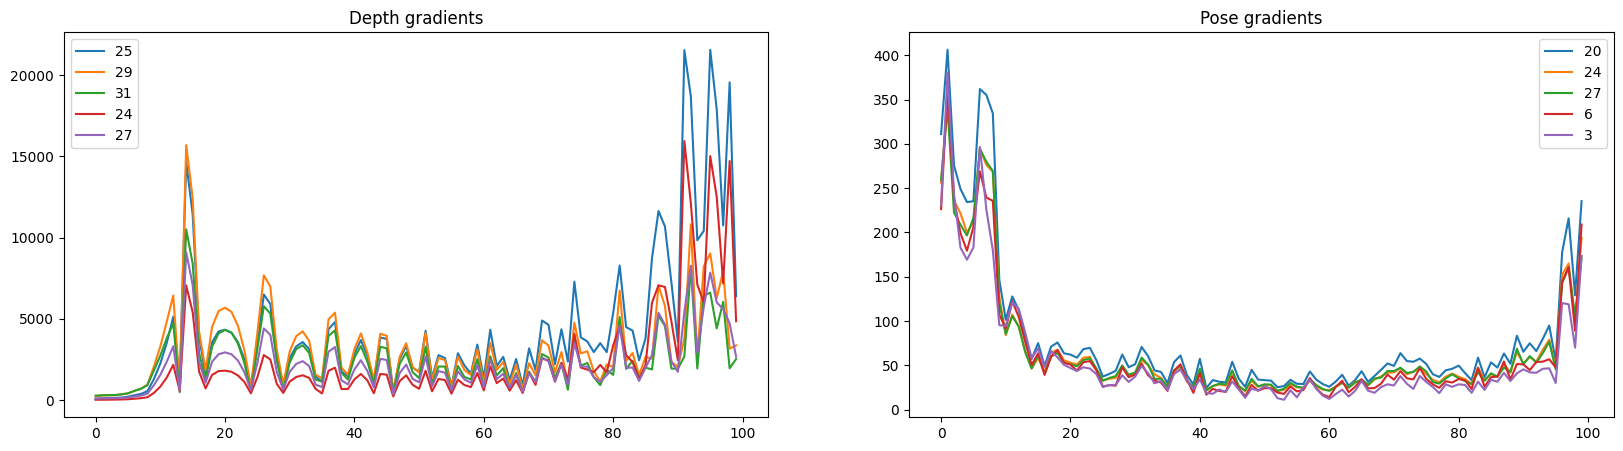

In [37]:
from rsl_depth_completion.conditional_diffusion.ssl_utils import plot_grads


plot_grads(depth_grads, pose_grads, topk=5)

In [12]:
do_save = False
if do_save:
    checkpoint_path = './models/kbnet'
    depth_model_checkpoint_path = os.path.join(checkpoint_path, 'depth_model-{}-epochs-overfit.pth')
    pose_model_checkpoint_path = os.path.join(checkpoint_path, 'pose_model-{}-epochs-overfit.pth')
    train_step=200
    depth_model.save_model(
        depth_model_checkpoint_path.format(train_step), train_step, optimizer)

    pose_model.save_model(
        pose_model_checkpoint_path.format(train_step), train_step, optimizer)


get kbnet pred for eval_batch

In [13]:
collect_kbnet_preds = False
if collect_kbnet_preds:
    ds.ds.do_crop = False
    sample0_idx = 310 + 5
    sample1_idx = 80 + 5
    kbnet_batch = torch.utils.data.default_collate([ds[sample0_idx], ds[sample1_idx]])
    kbnet_batch=eval_batch
    validity_map_depth_kbnet = torch.where(
                    kbnet_batch["sdm"] > 0, torch.ones_like(kbnet_batch["sdm"]), kbnet_batch["sdm"]
                ).bool()
    native_inputs = torch.load("/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/kbnet_native_val_inputs.pt")
    output_depth_kbnet = depth_model.forward(
        # **native_inputs
                image=kbnet_batch["rgb"]/255,
                sparse_depth=kbnet_batch["sdm"]*ds.ds.max_depth,
                validity_map_depth=validity_map_depth_kbnet,
                intrinsics=kbnet_batch["intrinsics"],
            )
    torch.save({cfg.input_res: output_depth_kbnet}, "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/kbnet_eval_batch_preds.pt")
    for kbnet_pred in output_depth_kbnet:
        plt.imshow(kbnet_pred[0].detach().cpu().numpy())
        plt.show()